# Scalable Machine Learning with Dask-ML

*https://coiled.io/blog/scalable-machine-learning.html*

Standard disclaimer: Python has great tools for single-node machine learning.
Distributed computing is fundamentally harder, so think twice before reaching for
Dask-ML.

In [ ]:
# This creates a Dask cluster with Coiled. To reproduce this
# with coiled you'd need to
# - visit https://coiled.io to sign up for an account.
# - Do their initial setup (login, create an environment)
# - change `account="dask"` to your account.
# Alternatively, you can deploy Dask on your own using one
# of the methods at https://docs.dask.org/en/latest/setup.html.

import coiled
cluster = coiled.Cluster(n_workers=20, account="dask")


from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tls://ec2-18-222-251-247.us-east-2.compute.amazonaws.com:8786 Dashboard: http://ec2-18-222-251-247.us-east-2.compute.amazonaws.com:8787/status,Cluster Workers: 20 Cores: 80 Memory: 343.60 GB


## When *might* you need scalable / distributed ML?

1. You have a compute-bound problem. Slow training time is affecting your workflow.
2. You have a memory-bound problem *and* more data helps.

## Dimensions of Scale

![](dimensions.png)

## 1. CPU (Compute)-Bound Problems

In this type of problem, your dataset fits in RAM just fine, but you're waiting around for your CPU (or GPU, TPU) to finish it's computations. This commonly occurs when there's many mostly independent components to your estimator

* Hyperparameter Optimization: Many CV-splits / hyperparameter combinations
* Ensemble estimator: Combine predictions from many estimators

These are relatively straightforward to parallelize. Here's a small example.

In [5]:
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

X, y = make_classification(n_samples=5_000, random_state=0)
X[:5]

param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
              "kernel": ['rbf', 'poly', 'sigmoid'],
              "shrinking": [True, False]}

grid_search = GridSearchCV(SVC(gamma='auto', random_state=0, probability=True),
                           param_grid=param_grid,
                           return_train_score=False,
                           cv=5,
                           n_jobs=-1)
grid_search

GridSearchCV(cv=5,
             estimator=SVC(gamma='auto', probability=True, random_state=0),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                         'kernel': ['rbf', 'poly', 'sigmoid'],
                         'shrinking': [True, False]})

Fitting a single estimator takes 1-2 seconds on my laptop.

In [6]:
%time grid_search.estimator.fit(X, y)

CPU times: user 1.13 s, sys: 21.3 ms, total: 1.15 s
Wall time: 1.15 s


SVC(gamma='auto', probability=True, random_state=0)

Now let's fit the whole grid search on the cluster.

In [7]:
%%time
import joblib

with joblib.parallel_backend('dask', scatter=[X, y]):
    grid_search.fit(X, y)

CPU times: user 2.4 s, sys: 144 ms, total: 2.55 s
Wall time: 14.2 s


## What Happened?

Internally, scikit-learn parallelizes `for` loops with joblib. Typically that parallel `for` loop uses threads or processes on a single machine. We worked with the scikit-learn / joblib devs to implement a `dask` parallel backend, so you can parallelize things on a cluster.

<img src="joblib.png" width="100%"/>

<img src="joblib-dask.png" width="100%"/>

Pretty much anything that uses joblib internally can use the Dask joblib backend.

* Anything in scikit-learn with `n_jobs` (fitting trees in a Random Forest, voting methods, hyperparamter optimization, ...)
* TPOT

## Real Example

Let's apply the joblib parallelization to a more realistic example.

We'll load a tiny fraction of the NYC taxi cab dataset. We'll have a blob of code to transform the heterogenous features into a nice array of floats that we can use in an estimator (GradientBoostingClassifier).

In [8]:
import dask.dataframe as dd

df = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv",
    dtype={
        "payment_type": "UInt8",
        "VendorID": "UInt8",
        "passenger_count": "UInt8",
        "RatecodeID": "UInt8",
    },
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"],
    blocksize="16 MiB",
    storage_options=dict(anon=True),
)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
npartitions=471,,,,,,,,,,,,,,,,,,
,UInt8,datetime64[ns],datetime64[ns],UInt8,float64,UInt8,object,int64,int64,UInt8,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


This is our "small" dataframe, with ~80,000 rows. I'll bring it back locally to my laptop with a `.compute()`. **This next section only uses pandas, NumPy, and scikit-learn.**

In [11]:
sdf = df.sample(frac=0.001, random_state=0).compute()
sdf.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
55481,2,2019-01-01 04:15:30,2019-01-01 04:20:09,3,0.78,1,N,41,152,1,5.0,0.5,0.5,0.0,0.0,0.3,6.3,NaN
160035,2,2019-01-01 19:00:30,2019-01-01 19:12:27,1,2.80,1,N,13,234,2,11.0,0.0,0.5,0.0,0.0,0.3,11.8,NaN
110985,2,2019-01-01 14:13:09,2019-01-01 14:16:10,1,0.67,1,N,170,162,2,4.5,0.0,0.5,0.0,0.0,0.3,5.3,NaN
17564,1,2019-01-01 01:39:24,2019-01-01 01:48:26,1,2.10,1,N,142,236,1,9.0,0.5,0.5,1.5,0.0,0.3,11.8,NaN
126418,1,2019-01-01 16:43:36,2019-01-01 16:50:43,1,1.20,1,N,137,224,2,7.0,0.0,0.5,0.0,0.0,0.3,7.8,NaN


In [99]:
sdf = sdf.dropna()
len(sdf)

79303

In [100]:
sdf.dtypes

VendorID                       category
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                     category
store_and_fwd_flag             category
PULocationID                      int64
DOLocationID                      int64
payment_type                   category
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

Let's fix up the dtypes (since we read from CSV, which doesn't have pandas' dtypes), drop the missing values, and split into our features and outcome variables.

In [101]:
import pandas as pd

vendor_dtype = pd.CategoricalDtype([1, 2, 4])
ratecode_dtype = pd.CategoricalDtype([1, 2, 3, 4, 5, 6, 99])
store_and_fwd_flag = pd.CategoricalDtype(["N", "Y"])
payment_type = pd.CategoricalDtype([1, 2, 3, 4, 5])

dtypes = {
    "VendorID": vendor_dtype,
    "RatecodeID": ratecode_dtype,
    "store_and_fwd_flag": store_and_fwd_flag,
    "payment_type": payment_type,
    "passenger_count": "int",
}
sdf = sdf.astype(dtypes)
X = sdf.drop(["tip_amount", "total_amount"], axis="columns")
y = sdf["tip_amount"] > 0
y.mean()

0.6925084801331601

And now we'll build up a big pre-processing pipeline. Note that we aren't doing anything with Dask / Dask-ML here. It's all NumPy, pandas, and scikit-learn.

In [108]:
import sklearn.pipeline
import sklearn.compose
import sklearn.preprocessing
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
import sklearn.ensemble

def transform_datetime(X):
    out = []
    for k, v in X.items():
        out.append(v.dt.dayofweek.rename(f"{k}_dow"))
        out.append(v.dt.hour.rename(f"{k}_hour"))

    return pd.concat(out, axis="columns")

def transform_location(X):    
    return (X["PULocationID"] == X["DOLocationID"]).to_frame(
        name="same_location"
    )


# Dummy encode the categorical columns
onehot_columns = list(sdf.select_dtypes(include="category"))
onehot_categories = [sdf[col].dtype.categories for col in onehot_columns]
ohe = sklearn.preprocessing.OneHotEncoder(categories=onehot_categories, sparse=False)

# Datetime & Dummy encode the datetime columns
datetime_columns = list(sdf.select_dtypes(include="datetime"))
dte = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.FunctionTransformer(transform_datetime),
    sklearn.preprocessing.OneHotEncoder( 
        categories=[
            list(range(7)),  # day of week
            list(range(24))  # hour
        ] * len(datetime_columns),
        sparse=False,
    )
)

# Location encode location IDs
location_columns = ["PULocationID", "DOLocationID"]
le = sklearn.preprocessing.FunctionTransformer(transform_location)

# Compose the pipeline
preprocess = sklearn.compose.make_column_transformer(
    (ohe, onehot_columns),
    (dte, datetime_columns),
    (le, location_columns),
    remainder="passthrough"
)

scale = sklearn.preprocessing.StandardScaler()

pipe = sklearn.pipeline.make_pipeline(
    preprocess,
    scale,
    sklearn.ensemble.GradientBoostingClassifier(),
)

In [103]:
sklearn.set_config(display="diagram")
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[Int64Index([1, 2, 4], dtype='int64'),
                                                                            Int64Index([1, 2, 3, 4, 5, 6, 99], dtype='int64'),
                                                                            Index(['N', 'Y'], dtype='object'),
                                                                            Int64Index([1, 2, 3, 4, 5], dtype='int64')],
                                                                sparse=False),
                                                  ['VendorID', 'RatecodeID',
                                                   'store_and_fwd_flag',
                                                   'payme...
                                                                                              2,
                                                                                              3,
                                                                                              4,
                                                                                              5,
                                                                                              6,
                                                                                              7,
                                                                                              8,
                                                                                              9,
                                                                                              10,
                                                                                              11,
                                                                                              12,
                                                                                              13,
                                                                                              14,
                                                                                              15,
                                                                                              16,
                                                                                              17,
                                                                                              18,
                                                                                              19,
                                                                                              20,
                                                                                              21,
                                                                                              22,
                                                                                              23]],
                                                                                 sparse=False))]),
                                                  ['tpep_pickup_datetime',
                                                   'tpep_dropoff_datetime']),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function transform_location at 0x165f28670>),
                                                  ['PULocationID',
                                                   'DOLocationID'])])),
                ('standardscaler', StandardScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

We can fit the pipeline on the small sample locally.

In [18]:
%time _ = pipe.fit(X, y)

CPU times: user 23 s, sys: 202 ms, total: 23.2 s
Wall time: 23.2 s


It ends up doing really well (or perhaps it's overfitting).

In [19]:
pipe.score(X, y)

0.9732923092442909

We'll do a grid search over some hyperparameters on the cluster now, using `dask_ml.model_selection.GridSearchCV`.

In [20]:
import dask_ml.model_selection

param_grid = {
    "gradientboostingclassifier__learning_rate": [0.001, 0.01, .1, 1],
    "gradientboostingclassifier__max_leaf_nodes": [10, 31, 50],
}
search = dask_ml.model_selection.GridSearchCV(pipe, param_grid)
search

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categories=[Int64Index([1, 2, 4], dtype='int64'),
                                                                                                   Int64Index([1, 2, 3, 4, 5, 6, 99], dtype='int64'),
                                                                                                   Index(['N', 'Y'], dtype='object'),
                                                                                                   Int64Index([1, 2, 3, 4, 5], dtype='int64')],
                                                                                       sparse=False),
                                                                         ['VendorID',
                                                                          'RatecodeID',
                                                                          'sto...
                                                                        ('functiontransformer',
                                                                         FunctionTransformer(func=<function transform_location at 0x160002820>),
                                                                         ['PULocationID',
                                                                          'DOLocationID'])])),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier())]),
             param_grid={'gradientboostingclassifier__learning_rate': [0.001,
                                                                       0.01,
                                                                       0.1, 1],
                         'gradientboostingclassifier__max_leaf_nodes': [10, 31,
                                                                        50]})

If you watch the progress bars closely, you'll see we only had 3 tasks for all the pre-processing stuff (StandardScalar, ColumnTransformer, etc.), while we had 36 for gradient boosting. That's because dask-ml's hyperparamter optimizers [avoid repeated work](https://ml.dask.org/hyper-parameter-search.html#avoid-repeated-work). We're only searching over parameters later on in the pipeline (the gradient boosting classifier), so all those can share the results of the earlier stages of the pipeline (for that CV split of the data).

In [21]:
%%time
_ = search.fit(X[:50_000], y[:50_000])

CPU times: user 642 ms, sys: 50.4 ms, total: 693 ms
Wall time: 1min 2s


## 2. Memory-Bound Problems

![](dimensions.png)

Dask-ML also has tools for working with larger-than-memory datasets. We can break this "large data" scaling challenge into a couple components

1. Data structures: NumPy & pandas were built for in-memory problems.
2. ML Algorithms: Many algorithms in (e.g.) Scikit-Learn were built for (in-memory) NumPy arrays.

Let's try migragting that earlier pre-processing code to Dask / Dask-ML. To fix the first issue, we'll swap out Dask Array and DataFrame for NumPy arrays and pandas DataFrames. This can be a simple as replacing an import, but often requires a bit of thought about where data resides and what triggers computation.

We'll see how to address the second issue -- that not all algorithms can handle distributed datasets -- later on.

*Note: This failed horribly during the live demo. I'll annotate what didn't work well.*

We'll start with the `dropna` and `astype`, which lived outside of the main pipeline.

In [64]:
from distributed import wait

In [69]:
df2 = df.dropna().astype(dtypes).persist()
wait(df2)
df2 = df2.repartition(partition_size="50 Mb")

big_X = df2.drop(["tip_amount", "total_amount"], axis="columns")
big_y = df2["tip_amount"] > 0

We have a large enough cluster to load the full dataset into memory. This is often a good idea after doing things like I/O or a big shuffle / join, which are relatively slow.

We also did a `repartition` there. Things were a bit imbalanced after the dropna (some partitions had 0 observations, which will become important later when we do per-partition operations).

In [72]:
big_X

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge
npartitions=221,,,,,,,,,,,,,,,,
,category[known],datetime64[ns],datetime64[ns],int64,float64,category[known],category[known],int64,int64,category[known],float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [73]:
big_y

Dask Series Structure:
npartitions=221
    bool
     ...
    ... 
     ...
     ...
Name: tip_amount, dtype: bool
Dask Name: gt, 1134 tasks

What did we change?

* `pd.concat` -> `dd.concat`
* `sklearn.preprocessing.OneHotEncoder` -> `dask_ml.preprocessing.OneHotEncoder`
* Convert to Categorical in transform_datetime
* Added an `as_float` estimator to convert the Dask DataFrame to a homogenous Dask Array
* Changed `GradientBoostingClassifier` -> an ensemble of linear models.

What didn't immediately work

* `DataFrame.items` wasn't implemented until a couple days ago
* `list(DataFrame)` triggered computation: https://github.com/dask/dask/issues/6513
* Can't specify `categories` in `dask_ml.model_selection.OneHotEncoder` for dataframes (have to use `CategoricalDtype` instead).

In [74]:
import dask_ml.preprocessing
import dask_ml.compose

There are a couple changes to the one-hot encoder. The biggest is that we
use `dask_ml.preprocessing.OneHotEncoder`, which understands how to encoded Dask Arrays / DataFrames. In particular, we rely on it using the `CategoricalDtype`s to know what the output shape should be. This is crucially important for Dask, which preferse to operate lazily. By default scikit-learn finds the categories by scanning the values in `.fit` to see all the unique values. We want to avoid that, since scanning all the values is relatively expensive on this large dataset.

Note that the `ohe.fit_transform` is instant, since we're just operating on metadata here.

In [75]:
# Dummy encode the categorical columns
onehot_columns = list(big_X.select_dtypes(include="category").columns)
ohe = dask_ml.preprocessing.OneHotEncoder(
    sparse=False
)
ohe.fit_transform(big_X[onehot_columns])

,VendorID_1,VendorID_2,VendorID_4,RatecodeID_1,RatecodeID_2,RatecodeID_3,RatecodeID_4,RatecodeID_5,RatecodeID_6,RatecodeID_99,store_and_fwd_flag_N,store_and_fwd_flag_Y,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5
npartitions=221,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


For the datetime columns, the major change is to convert the values to CategoricalDtype in the `transform_datetime` function. That lines us up to use `dask_ml.preprocessing.OneHotEncoder`. Again, this is instant since we're using the dtypes to know what the output type / shape should be.

In [98]:
# Datetime & Dummy encode the datetime columns
def transform_datetime(X):
    out = []
    for k in X.columns:
        v = X[k] 
        out.append(v.dt.dayofweek.rename(f"{k}_dow").astype(
            pd.CategoricalDtype(list(range(7)))
        ))
        out.append(v.dt.hour.rename(f"{k}_hour").astype(
            pd.CategoricalDtype(list(range(24))),
        ))

    return dd.concat(out, axis="columns", ignore_unknown_divisions=True)


datetime_columns = list(big_X.select_dtypes(include="datetime").columns)
dte = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.FunctionTransformer(transform_datetime),
    dask_ml.preprocessing.OneHotEncoder( 
        sparse=False,
    )
)
dte.fit_transform(big_X[datetime_columns])

,tpep_pickup_datetime_dow_0,tpep_pickup_datetime_dow_1,tpep_pickup_datetime_dow_2,tpep_pickup_datetime_dow_3,tpep_pickup_datetime_dow_4,tpep_pickup_datetime_dow_5,tpep_pickup_datetime_dow_6,tpep_pickup_datetime_hour_0,tpep_pickup_datetime_hour_1,tpep_pickup_datetime_hour_2,tpep_pickup_datetime_hour_3,tpep_pickup_datetime_hour_4,tpep_pickup_datetime_hour_5,tpep_pickup_datetime_hour_6,tpep_pickup_datetime_hour_7,tpep_pickup_datetime_hour_8,tpep_pickup_datetime_hour_9,tpep_pickup_datetime_hour_10,tpep_pickup_datetime_hour_11,tpep_pickup_datetime_hour_12,tpep_pickup_datetime_hour_13,tpep_pickup_datetime_hour_14,tpep_pickup_datetime_hour_15,tpep_pickup_datetime_hour_16,tpep_pickup_datetime_hour_17,tpep_pickup_datetime_hour_18,tpep_pickup_datetime_hour_19,tpep_pickup_datetime_hour_20,tpep_pickup_datetime_hour_21,tpep_pickup_datetime_hour_22,tpep_pickup_datetime_hour_23,tpep_dropoff_datetime_dow_0,tpep_dropoff_datetime_dow_1,tpep_dropoff_datetime_dow_2,tpep_dropoff_datetime_dow_3,tpep_dropoff_datetime_dow_4,tpep_dropoff_datetime_dow_5,tpep_dropoff_datetime_dow_6,tpep_dropoff_datetime_hour_0,tpep_dropoff_datetime_hour_1,tpep_dropoff_datetime_hour_2,tpep_dropoff_datetime_hour_3,tpep_dropoff_datetime_hour_4,tpep_dropoff_datetime_hour_5,tpep_dropoff_datetime_hour_6,tpep_dropoff_datetime_hour_7,tpep_dropoff_datetime_hour_8,tpep_dropoff_datetime_hour_9,tpep_dropoff_datetime_hour_10,tpep_dropoff_datetime_hour_11,tpep_dropoff_datetime_hour_12,tpep_dropoff_datetime_hour_13,tpep_dropoff_datetime_hour_14,tpep_dropoff_datetime_hour_15,tpep_dropoff_datetime_hour_16,tpep_dropoff_datetime_hour_17,tpep_dropoff_datetime_hour_18,tpep_dropoff_datetime_hour_19,tpep_dropoff_datetime_hour_20,tpep_dropoff_datetime_hour_21,tpep_dropoff_datetime_hour_22,tpep_dropoff_datetime_hour_23
npartitions=221,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Finally we do our location encoding. This code is identical to before. It works fine on either dask or pandas dataframes. And notice that we're still using `sklearn.preprocessing.FunctionTransformer`.

In [77]:
# Location encode location IDs

def transform_location(X):
    return (X["PULocationID"] == X["DOLocationID"]).to_frame(
        name="same_location"
    )


location_columns = ["PULocationID", "DOLocationID"]
le = sklearn.preprocessing.FunctionTransformer(transform_location)

Finally, we can stich everything together with `dask_ml.compose.make_column_transformer`. We're close to being able to just use `sklearn.compose.make_column_transformer`, but we need a bit of custom logic to be able to concatenate together the various transformers (scikit-learn's just uses `np.concat` or `scipy.sparse.concat`; we need to be able to handle Dask DataFrames).

In [105]:
# Compose the pipeline
big_preprocess = dask_ml.compose.make_column_transformer(
    (ohe, onehot_columns),
    (dte, datetime_columns),
    (le, location_columns),
    remainder="passthrough"
)

Finally, we'll convert to a Dask Array and scale the results.

In [106]:
# Convert to a floating-point Dask Array
as_float = sklearn.preprocessing.FunctionTransformer(
    lambda x: x.astype(float).to_dask_array(lengths=True)
)

Now, recall that the last stage from

This doesn't quite work, since `GradientBoostClassifier` would blow up if we passed it the big Dask DataFrame.

In [81]:
big_y2 = big_y.to_dask_array()

In [91]:
import dask_ml.ensemble

voter = dask_ml.ensemble.BlockwiseVotingClassifier(
    sklearn.linear_model.ElasticNet(),
    classes=[0, 1]
)

In [107]:
big_pipe = sklearn.pipeline.make_pipeline(
    big_preprocess,
    as_float,
    dask_ml.preprocessing.StandardScaler(),
    voter
)
big_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[Int64Index([1, 2, 4], dtype='int64'),
                                                                            Int64Index([1, 2, 3, 4, 5, 6, 99], dtype='int64'),
                                                                            Index(['N', 'Y'], dtype='object'),
                                                                            Int64Index([1, 2, 3, 4, 5], dtype='int64')],
                                                                sparse=False),
                                                  ['VendorID', 'RatecodeID',
                                                   'store_and_fwd_flag',
                                                   'payme...
                                                   'tpep_dropoff_datetime']),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function transform_location at 0x165f28670>),
                                                  ['PULocationID',
                                                   'DOLocationID'])])),
                ('functiontransformer',
                 FunctionTransformer(func=<function <lambda> at 0x165d7a1f0>)),
                ('standardscaler', StandardScaler()),
                ('blockwisevotingclassifier',
                 BlockwiseVotingClassifier(classes=[0, 1],
                                           estimator=ElasticNet()))])

In [93]:
%%time
_ = big_pipe.fit(big_X, big_y)

CPU times: user 3.34 s, sys: 126 ms, total: 3.47 s
Wall time: 1min 57s


In [95]:
yhat = big_pipe.predict(big_X)
yhat

,Array,Chunk
Bytes,634.37 MB,3.07 MB
Shape,"(79296437,)","(383367,)"
Count,7988 Tasks,221 Chunks
Type,int64,numpy.ndarray


## Plot Your Learning Curve!

We just did a very bad thing. We fit a model on a huge dataset without thinking about whether it was actually worth doing. That's what learning curves, which show the performance of a model as the number of examples increases, are designed to show.

Let's make a very simple / fast to train model.

In [109]:
import sklearn.linear_model

lr = sklearn.linear_model.LogisticRegression(max_iter=500)
pipe = sklearn.pipeline.make_pipeline(preprocess, scale, lr)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[Int64Index([1, 2, 4], dtype='int64'),
                                                                            Int64Index([1, 2, 3, 4, 5, 6, 99], dtype='int64'),
                                                                            Index(['N', 'Y'], dtype='object'),
                                                                            Int64Index([1, 2, 3, 4, 5], dtype='int64')],
                                                                sparse=False),
                                                  ['VendorID', 'RatecodeID',
                                                   'store_and_fwd_flag',
                                                   'payme...
                                                                                             [0,
                                                                                              1,
                                                                                              2,
                                                                                              3,
                                                                                              4,
                                                                                              5,
                                                                                              6,
                                                                                              7,
                                                                                              8,
                                                                                              9,
                                                                                              10,
                                                                                              11,
                                                                                              12,
                                                                                              13,
                                                                                              14,
                                                                                              15,
                                                                                              16,
                                                                                              17,
                                                                                              18,
                                                                                              19,
                                                                                              20,
                                                                                              21,
                                                                                              22,
                                                                                              23]],
                                                                                 sparse=False))]),
                                                  ['tpep_pickup_datetime',
                                                   'tpep_dropoff_datetime']),
                                                 ('functiontransformer',
                                                  FunctionTransformer(func=<function transform_location at 0x1655768b0>),
                                                  ['PULocationID',
                                                   'DOLocationID'])])),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [111]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We'll use scikit-learn's built-in [`learning_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html) to measure how the model does on various sample sizes (all of which fit in memory). It uses `joblib` internally, so we can use Dask to do the learning curve in parallel on the cluster.

In [112]:
xx = X[:50_000]
yy = y[:50_000]

with joblib.parallel_backend("dask", scatter=[xx, yy]):
    train_sizes, train_scores, test_scores, fit_times, _ = (
        sklearn.model_selection.learning_curve(pipe, xx, yy,
                                               return_times=True)
    )

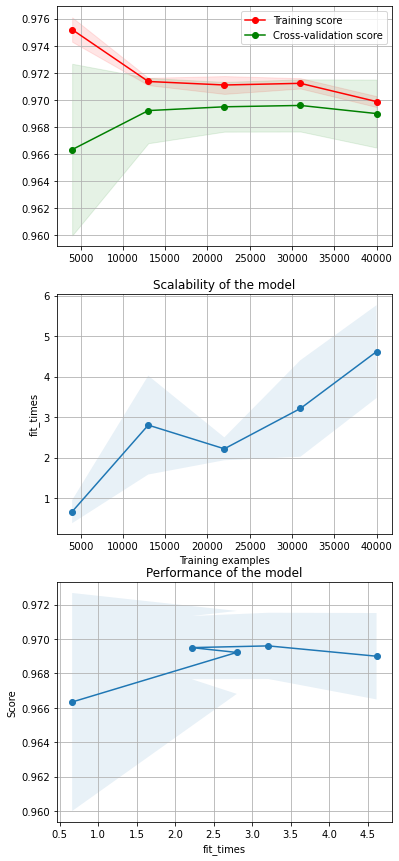

In [113]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)

fig, axes = plt.subplots(nrows=3, figsize=(6, 15))
# Plot learning curve
axes[0].grid()
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
axes[0].legend(loc="best")

# Plot n_samples vs fit_times
axes[1].grid()
axes[1].plot(train_sizes, fit_times_mean, 'o-')
axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                     fit_times_mean + fit_times_std, alpha=0.1)
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("fit_times")
axes[1].set_title("Scalability of the model")

# Plot fit_time vs score
axes[2].grid()
axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1)
axes[2].set_xlabel("fit_times")
axes[2].set_ylabel("Score")
axes[2].set_title("Performance of the model");

So this model overfits at 5,000 samples, but by 15,000 samples has essentially plateaued. Throwing more data at this model isn't really going to improve your fit.

## Hyperband

This also failed live. I mistakenly persisted two copies (random) datasets and had a bit too big of chunks for my tasks. The large chunks + a bit of data movement (to get all the `y`s on the same machine with their respective the `X`s) meant that we hit our worker's memory limits. This caused spilling to disk (yellowish-orange bars in the task graph). The solution was to generate slighly smaller chunks. Then everything went fine.

Dask-ML has a nice implementation of Hyperband, a hyperparameter optimization algorithm that works for large models and (if necessary) for larger than memory datasets. The basic idea is to feed some examples (rows in the dataset) to a bunch of models (different hyperparameter combinations). If a particular model seems to be doing well, it'll be fed more and more examples. If a model isn't doing well, we just stop training it. In the end, hyperband tends to do just as well as RandomizedSearchCV, but in less training time since it spends less time training "bad" models.

For Dask-ML, the crucial component is that the estimator needs to have a `.fit_partial` method. That's how we incrementally feed high-performing models more and more data points.

In [70]:
%matplotlib inline

In [137]:
import dask
import dask.array as da
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.neural_network import MLPClassifier

In [131]:
model = MLPClassifier()

params = {
    "hidden_layer_sizes": [
        (24, ),
        (12, 12),
        (6, 6, 6, 6),
        (4, 4, 4, 4, 4, 4),
        (12, 6, 3, 3),
    ],
    "activation": ["relu", "logistic", "tanh"],
    "alpha": np.logspace(-6, -3, num=1000),  # cnts
    "batch_size": [16, 32, 64, 128, 256, 512],
}
hyper_search = dask_ml.model_selection.HyperbandSearchCV(model, params)

In [132]:
import dask
import dask.array as da

import dask_ml.datasets

hyperX, hypery = dask_ml.datasets.make_classification(
    n_samples=10_000_000, n_features=300, chunks=100_000
)
hyperX

,Array,Chunk
Bytes,24.00 GB,240.00 MB
Shape,"(10000000, 300)","(100000, 300)"
Count,100 Tasks,100 Chunks
Type,float64,numpy.ndarray


In [133]:
hyperX, hypery = dask.persist(hyperX, hypery)

In [134]:
hyper_search

HyperbandSearchCV(estimator=MLPClassifier(),
                  parameters={'activation': ['relu', 'logistic', 'tanh'],
                              'alpha': array([1.00000000e-06, 1.00693863e-06, 1.01392541e-06, 1.02096066e-06,
       1.02804473e-06, 1.03517796e-06, 1.04236067e-06, 1.04959323e-06,
       1.05687597e-06, 1.06420924e-06, 1.07159340e-06, 1.07902879e-06,
       1.08651577e-06, 1.09405471e-06, 1.10164595e-06, 1.10928986e-06...
       9.01477631e-04, 9.07732653e-04, 9.14031075e-04, 9.20373200e-04,
       9.26759330e-04, 9.33189772e-04, 9.39664831e-04, 9.46184819e-04,
       9.52750047e-04, 9.59360829e-04, 9.66017480e-04, 9.72720319e-04,
       9.79469667e-04, 9.86265846e-04, 9.93109181e-04, 1.00000000e-03]),
                              'batch_size': [16, 32, 64, 128, 256, 512],
                              'hidden_layer_sizes': [(24,), (12, 12),
                                                     (6, 6, 6, 6),
                                                     (4, 4, 4, 4, 4, 4),
                                                     (12, 6, 3, 3)]})

In [135]:
hyper_search.fit(hyperX, hypery, classes=[0, 1])

/Users/taugspurger/miniconda3/envs/coiled-coiled-default/lib/python3.8/site-packages/dask_ml/model_selection/_incremental.py:617: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  cv_results = {k: np.array(v) for k, v in cv_results.items()}
/Users/taugspurger/miniconda3/envs/coiled-coiled-default/lib/python3.8/site-packages/dask_ml/model_selection/_hyperband.py:431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  cv_results = {k: np.array(v) for k, v in cv_results.items()}


HyperbandSearchCV(estimator=MLPClassifier(),
                  parameters={'activation': ['relu', 'logistic', 'tanh'],
                              'alpha': array([1.00000000e-06, 1.00693863e-06, 1.01392541e-06, 1.02096066e-06,
       1.02804473e-06, 1.03517796e-06, 1.04236067e-06, 1.04959323e-06,
       1.05687597e-06, 1.06420924e-06, 1.07159340e-06, 1.07902879e-06,
       1.08651577e-06, 1.09405471e-06, 1.10164595e-06, 1.10928986e-06...
       9.01477631e-04, 9.07732653e-04, 9.14031075e-04, 9.20373200e-04,
       9.26759330e-04, 9.33189772e-04, 9.39664831e-04, 9.46184819e-04,
       9.52750047e-04, 9.59360829e-04, 9.66017480e-04, 9.72720319e-04,
       9.79469667e-04, 9.86265846e-04, 9.93109181e-04, 1.00000000e-03]),
                              'batch_size': [16, 32, 64, 128, 256, 512],
                              'hidden_layer_sizes': [(24,), (12, 12),
                                                     (6, 6, 6, 6),
                                                     (4, 4, 4, 4, 4, 4),
                                                     (12, 6, 3, 3)]})

In [138]:
pd.DataFrame(hyper_search.cv_results_)

,model_id,mean_score_time,param_hidden_layer_sizes,params,rank_test_score,bracket,param_alpha,param_activation,param_batch_size,test_score,partial_fit_calls,mean_partial_fit_time,std_score_time,std_partial_fit_time
0,bracket=4-0,0.323054,"(12, 6, 3, 3)","{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",65,4,0.000421,relu,256,0.58772,1,5.611558,0.000000,0.000000
1,bracket=4-1,0.499037,"(4, 4, 4, 4, 4, 4)","{'hidden_layer_sizes': (4, 4, 4, 4, 4, 4), 'ba...",80,4,0.000003,logistic,128,0.49868,1,14.428890,0.000000,0.000000
2,bracket=4-2,0.251854,"(12, 12)","{'hidden_layer_sizes': (12, 12), 'batch_size':...",46,4,0.000040,logistic,256,0.62279,1,6.352800,0.000000,0.000000
3,bracket=4-3,0.187957,"(24,)","{'hidden_layer_sizes': (24,), 'batch_size': 64...",45,4,0.000081,relu,64,0.62304,1,13.554508,0.000000,0.000000
4,bracket=4-4,0.221775,"(24,)","{'hidden_layer_sizes': (24,), 'batch_size': 25...",15,4,0.000003,logistic,256,0.63209,3,3.764606,0.008316,0.287161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,bracket=0-0,0.169789,"(6, 6, 6, 6)","{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",3,0,0.000092,logistic,32,0.63435,81,5.782975,0.032766,1.824759
139,bracket=0-1,0.208682,"(12, 6, 3, 3)","{'hidden_layer_sizes': (12, 6, 3, 3), 'batch_s...",5,0,0.000347,tanh,16,0.63172,81,11.764629,0.018084,3.887606
140,bracket=0-2,0.107165,"(6, 6, 6, 6)","{'hidden_layer_sizes': (6, 6, 6, 6), 'batch_si...",1,0,0.000052,relu,512,0.63643,81,1.493981,0.008409,0.317677
141,bracket=0-3,0.198594,"(24,)","{'hidden_layer_sizes': (24,), 'batch_size': 32...",4,0,0.000418,logistic,32,0.63396,81,4.678411,0.035906,1.786845


At this point, things did fine.

You might want to check the example at https://examples.dask.org/machine-learning/hyperparam-opt.html. There's a bunch of ML examples at https://examples.dask.org, and the main documentation for Dask-ML is at https://ml.dask.org.